# Import Library

In [ ]:
import numpy as np
import math
import natsort
import cv2
import os
import matplotlib.pyplot as plt
from google.colab import drive
from glob import glob

import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loder

In [1]:
def sortlist(filelist):
    filelist = natsort.natsorted(filelist)
    return filelist

In [2]:
dir_path = '/content/drive/MyDrive/Cloud_data/cloud_train'
input_images = glob(os.path.join(dir_path, "patch_img", "*png"))
input_images = sortlist(input_images)

NameError: name 'glob' is not defined

In [3]:
print(len(input_images))

NameError: name 'input_images' is not defined

In [ ]:
asd = '/content/drive/MyDrive/Cloud_data/cloud_train/patch_label'
asd =  glob(os.path.join(asd,"*png"))
asd = sortlist(asd)
print(asd[0])

/content/drive/MyDrive/Cloud_data/cloud_train/patch_label/img1_1.png


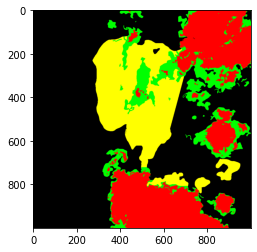

In [ ]:
zxc = cv2.imread(asd[1])
zxc = cv2.cvtColor(zxc, cv2.COLOR_BGR2RGB)
plt.imshow(zxc)
plt.show()

In [142]:
# np.unique(zxc)
# zxc.shape[:,:,0]
iop = np.asarray(zxc)
print(type(iop))
iop[:,:,0]  # 0:R, 1:G , 2:B
#  r   g  b
#  0   0  0 : 0
# 255  0  0 : 1
#  0  255 0 : 2
# 255 255 0 : 3

<class 'numpy.ndarray'>


array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [ ]:
class CloudGenerator(Sequence):
    def __init__(self,
                 dir_path,
                 batch_size = 16,
                 img_size = (1000,1000,3),
                 output_size = (1000,1000),
                 is_train = True):
        
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.output_size = output_size
        self.is_train = is_train

        self.data = self.load_dataset()
    
    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path,"patch_img","*png"))
        label_images = glob(os.path.join(self.dir_path,"patch_label","*png"))
        
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]
        train_percent = len(data) * 0.8

        if self.is_train:
            return data[:train_percent]
        return data[train_percent:]

    def __getitem__(self, index):
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = cv2.imread(input_img_path)
            _output = cv2.imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [ ]:
train_generator = CloudGenerator(
    dir_path
)

test_generator = CloudGenerator(
    dir_path,
    is_train=False
)

# Build U-net Model

In [ ]:
def build_unet_model(input_shape=(1000, 1000, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [ ]:
unet_model_path = '/content/drive/MyDrive/Cloud_data/cloud_model/seg_unet_model.h5'

unet_model = build_unet_model()
unet_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unet_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_model.save(unet_model_path)  #학습한 모델을 저장해 주세요.

In [12]:
4